# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 5.4MB 7.0MB/s 
     |████████████████████████████████| 9.5MB 49.2MB/s 
     |████████████████████████████████| 26.6MB 89kB/s 
     |████████████████████████████████| 2.6MB 54.5MB/s 
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=b89aef51f14ffec2e462946e07416b664bfcab8ce76dd3dd4e4be0c13197866f
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=f443c9fa71d47e84cc1c0a4faeaaddf79f114dc38895f94a2fb2549732c6119c
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=d6c26dc29ba1a6db66bdd7df5d263db8ae27b55e37ccd7c87175249fb1a3f599
  Stored in directory: /root/.cache/pip/wh

# Importing Data

In [3]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')    

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test=pd.read_csv('/content/drive/MyDrive/test.csv')

In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Data Exploration

Checking for missing values

In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [10]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [11]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [12]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [13]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

## Lemmatization

In [14]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [15]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()

In [17]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [18]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

In [19]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [20]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

## Stopwords Removal

In [21]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [22]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [23]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [24]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [25]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [26]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

In [27]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [28]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [29]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [30]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [31]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [32]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [33]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [34]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [35]:
print(common_potential_stopwords)

['good', 'try', 'change', 'image', 'user', 'source', 'need', 'point', 'page', 'don', 'block', 'comment', 'section', 'work', 'question', 'time', 'thing', 'delete', 'people', 'like', 'add', 'deletion', 'wikipedia', 'thank', 'link', 'help', 'way', 'list', 'want', 'editor', 'article', 'talk', 'find', 'remove', 'fuck', 'doe', 'edit', 'look', 'think', 'fact', 'read', 'mean', 'new', 'use', 'reference', 'information', 'write', 'know']


Retaining certain words and removing others from the above list

In [36]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [37]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [38]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [39]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

In [40]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [41]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

# Model Building

In [42]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [43]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [44]:
import pickle
with open('/content/drive/MyDrive/tokenizer.txt', 'wb') as t:
   pickle.dump(tokenizer, t)

In [45]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


Padding

In [46]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [47]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [48]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [49]:
X_t = X_t[indices]
labels = y[indices]

### Splitting data into Training and Validation Set

In [50]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [51]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12297  1266  6778   385  6285  1132]
validation:  [2997  329 1671   93 1592  273]


### Importing Fast Text

In [52]:
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/test_labels.csv', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [53]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


### Creating Model

#### Talos Grid Search  for LSTM Model

In [54]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [55]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [56]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 81s 12ms/step - loss: 0.1295 - accuracy: 0.8623 - val_loss: 0.0725 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0742 - accuracy: 0.9941 - val_loss: 0.0657 - val_accuracy: 0.9933


  6%|▌         | 1/18 [02:17<38:54, 137.33s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.1280 - accuracy: 0.8214 - val_loss: 0.0743 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0755 - accuracy: 0.9940 - val_loss: 0.0653 - val_accuracy: 0.9933


 11%|█         | 2/18 [04:00<33:53, 127.07s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.1275 - accuracy: 0.8056 - val_loss: 0.0750 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0733 - accuracy: 0.9940 - val_loss: 0.0636 - val_accuracy: 0.9933


 17%|█▋        | 3/18 [05:43<29:58, 119.92s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.1272 - accuracy: 0.8010 - val_loss: 0.0710 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0725 - accuracy: 0.9942 - val_loss: 0.0632 - val_accuracy: 0.9933


 22%|██▏       | 4/18 [07:23<26:36, 114.02s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.1259 - accuracy: 0.8377 - val_loss: 0.0712 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0709 - accuracy: 0.9941 - val_loss: 0.0629 - val_accuracy: 0.9933


 28%|██▊       | 5/18 [09:04<23:51, 110.13s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.1163 - accuracy: 0.8488 - val_loss: 0.0792 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0722 - accuracy: 0.9942 - val_loss: 0.0650 - val_accuracy: 0.9933


 33%|███▎      | 6/18 [10:46<21:29, 107.48s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.1257 - accuracy: 0.8034 - val_loss: 0.0694 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0713 - accuracy: 0.9940 - val_loss: 0.0636 - val_accuracy: 0.9933


 39%|███▉      | 7/18 [12:26<19:16, 105.18s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.1242 - accuracy: 0.8450 - val_loss: 0.0666 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0684 - accuracy: 0.9945 - val_loss: 0.0650 - val_accuracy: 0.9933


 44%|████▍     | 8/18 [14:06<17:17, 103.78s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 54s 13ms/step - loss: 0.1191 - accuracy: 0.8636 - val_loss: 0.0690 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0704 - accuracy: 0.9936 - val_loss: 0.0632 - val_accuracy: 0.9933


 50%|█████     | 9/18 [15:51<15:36, 104.08s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.1340 - accuracy: 0.7886 - val_loss: 0.0735 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0749 - accuracy: 0.9945 - val_loss: 0.0679 - val_accuracy: 0.9933


 56%|█████▌    | 10/18 [17:27<13:33, 101.74s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.1457 - accuracy: 0.7793 - val_loss: 0.0762 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0793 - accuracy: 0.9943 - val_loss: 0.0727 - val_accuracy: 0.9933


 61%|██████    | 11/18 [19:03<11:40, 100.04s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.1322 - accuracy: 0.8089 - val_loss: 0.0766 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0768 - accuracy: 0.9942 - val_loss: 0.0687 - val_accuracy: 0.9933


 67%|██████▋   | 12/18 [20:41<09:56, 99.36s/it] 

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.1337 - accuracy: 0.7910 - val_loss: 0.0731 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0764 - accuracy: 0.9942 - val_loss: 0.0670 - val_accuracy: 0.9933


 72%|███████▏  | 13/18 [22:17<08:11, 98.35s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.1306 - accuracy: 0.7679 - val_loss: 0.0742 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0751 - accuracy: 0.9942 - val_loss: 0.0662 - val_accuracy: 0.9933


 78%|███████▊  | 14/18 [23:54<06:31, 97.84s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.1273 - accuracy: 0.8205 - val_loss: 0.0771 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0776 - accuracy: 0.9934 - val_loss: 0.0672 - val_accuracy: 0.9933


 83%|████████▎ | 15/18 [25:30<04:52, 97.39s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.1285 - accuracy: 0.8446 - val_loss: 0.0714 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0772 - accuracy: 0.9942 - val_loss: 0.0676 - val_accuracy: 0.9933


 89%|████████▉ | 16/18 [27:04<03:12, 96.35s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.1279 - accuracy: 0.7692 - val_loss: 0.0748 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0775 - accuracy: 0.9937 - val_loss: 0.0675 - val_accuracy: 0.9933


 94%|█████████▍| 17/18 [28:41<01:36, 96.53s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.1203 - accuracy: 0.8438 - val_loss: 0.0722 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0747 - accuracy: 0.9940 - val_loss: 0.0638 - val_accuracy: 0.9933


100%|██████████| 18/18 [30:17<00:00, 100.96s/it]


In [57]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [58]:
analyze_object = talos.Analyze(scan_results)

In [59]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[40, 'adam', 30, 32, 2, '04/13/21-102230', 'relu', 'sigmoid', 2,
        136.65377402305603, 0.1, '04/13/21-102447', 0],
       [50, 'adam', 30, 32, 2, '04/13/21-102447', 'relu', 'sigmoid', 2,
        102.48874640464783, 0.1, '04/13/21-102630', 1],
       [50, 'adam', 50, 32, 2, '04/13/21-104935', 'relu', 'sigmoid', 2,
        96.29205441474915, 0.2, '04/13/21-105111', 2],
       [40, 'adam', 50, 32, 2, '04/13/21-104801', 'relu', 'sigmoid', 2,
        93.31062746047974, 0.2, '04/13/21-104934', 3],
       [60, 'adam', 40, 32, 2, '04/13/21-104624', 'relu', 'sigmoid', 2,
        95.6870174407959, 0.2, '04/13/21-104800', 4],
       [50, 'adam', 40, 32, 2, '04/13/21-104448', 'relu', 'sigmoid', 2,
        96.00368452072144, 0.2, '04/13/21-104624', 5],
       [40, 'adam', 40, 32, 2, '04/13/21-104312', 'relu', 'sigmoid', 2,
        95.37381553649902, 0.2, '04/13/21-104447', 6],
       [60, 'adam', 30, 32, 2, '04/13/21-104134', 'relu', 'sigmoid', 2,
        97.11842322349548, 0.2, '04/13

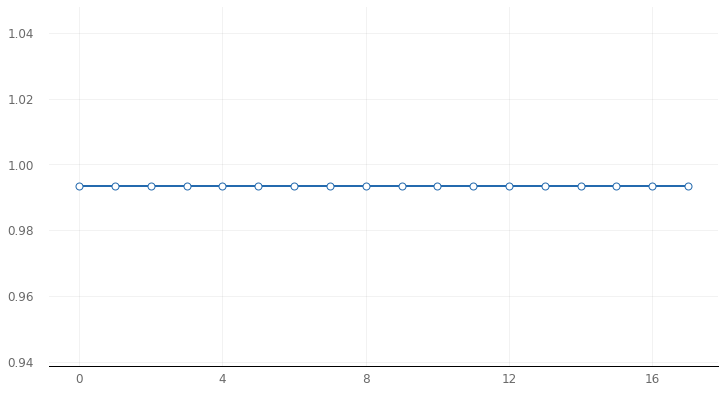

In [60]:
analyze_object.plot_line('val_accuracy')

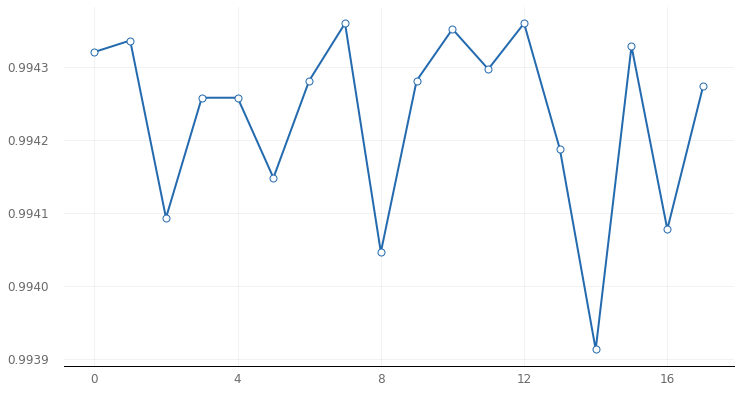

In [61]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [62]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [63]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [64]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [65]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [66]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 300)          44675400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 40)           54560     
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0     

In [67]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.1312 - accuracy: 0.8191 - val_loss: 0.0703 - val_accuracy: 0.9929
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0703 - accuracy: 0.9919 - val_loss: 0.0628 - val_accuracy: 0.9933


## Plotting Graphs

### LSTM

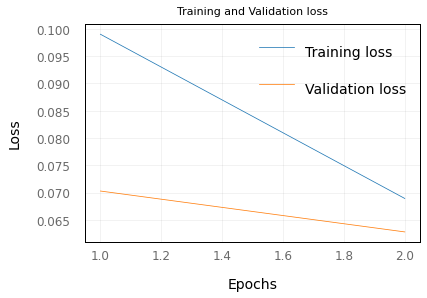

In [68]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

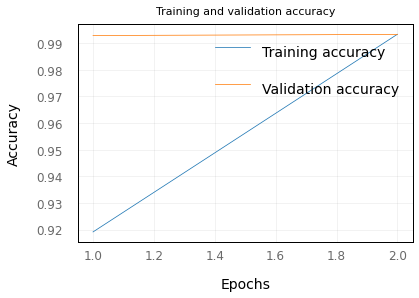

In [69]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [70]:
model_1.save(filepath="/content/drive/MyDrive/Models_1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models_1/assets


# Loading Saved Model

In [71]:
loaded_model_1 = keras.models.load_model(filepath="/content/drive/MyDrive/Models_1")

# Generating the Output

### LSTM

In [72]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 526s 3ms/step


In [73]:
sample_submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/submission1.csv', index=False)

# Testing the Created Model

In [74]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_1.predict(new_string)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [75]:
toxicity_level('go jump off a bridge jerk')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         72%
Severe Toxic:  2%
Obscene:       37%
Threat:        1%
Insult:        33%
Identity Hate: 2%



In [76]:
toxicity_level("I would like to punch you.")

Toxicity levels for 'I would like to punch you.':
Toxic:         10%
Severe Toxic:  0%
Obscene:       2%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [77]:
toxicity_level('i will kill you')

Toxicity levels for 'i will kill you':
Toxic:         26%
Severe Toxic:  1%
Obscene:       10%
Threat:        2%
Insult:        10%
Identity Hate: 2%



In [78]:
toxicity_level('have a nice day')

Toxicity levels for 'have a nice day':
Toxic:         10%
Severe Toxic:  0%
Obscene:       2%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [79]:
toxicity_level('fuck ofF!!')

Toxicity levels for 'fuck ofF!!':
Toxic:         100%
Severe Toxic:  30%
Obscene:       98%
Threat:        3%
Insult:        79%
Identity Hate: 6%



In [80]:
toxicity_level('yo bitch')

Toxicity levels for 'yo bitch':
Toxic:         99%
Severe Toxic:  12%
Obscene:       93%
Threat:        2%
Insult:        78%
Identity Hate: 4%



In [81]:
toxicity_level('nigger')

Toxicity levels for 'nigger':
Toxic:         91%
Severe Toxic:  19%
Obscene:       72%
Threat:        6%
Insult:        64%
Identity Hate: 18%



In [82]:
toxicity_level('hey nigger')

Toxicity levels for 'hey nigger':
Toxic:         87%
Severe Toxic:  14%
Obscene:       64%
Threat:        5%
Insult:        58%
Identity Hate: 16%



In [83]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         8%
Severe Toxic:  0%
Obscene:       2%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [84]:
toxicity_level('get the fuck away from me @sshole!!')

Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         99%
Severe Toxic:  17%
Obscene:       94%
Threat:        3%
Insult:        69%
Identity Hate: 5%

